In [21]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix,classification_report, roc_curve, log_loss, brier_score_loss, roc_auc_score
from timeit import default_timer as timer

In [2]:
#murders_full = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_short.csv')
murders_no_unknowns = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns.csv')
#murders_unknown_ethnic = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns_except_VicEthnic.csv')

Models using no_unknowns (smallest and cleanest) dataset (with MSA excluded for now):

In [3]:
murders_no_unknowns.Solved.value_counts()

Yes    220148
No      88813
Name: Solved, dtype: int64

In [4]:
# Balance

solved_count, unsolved_count = murders_no_unknowns.Solved.value_counts()
solved = murders_no_unknowns[murders_no_unknowns.Solved == 'Yes']
unsolved = murders_no_unknowns[murders_no_unknowns.Solved == 'No']
solved_sample = solved.sample(unsolved_count)

murders_no_unknowns = pd.concat([unsolved, solved_sample], axis = 0)

murders_no_unknowns.Solved.value_counts()

No     88813
Yes    88813
Name: Solved, dtype: int64

In [5]:
start_preprocessing = timer()

#Create dummy columns for categorical features
model_df = pd.get_dummies(murders_no_unknowns[['Agentype',
                                   'Month',
                                   'Homicide',
                                   'Situation',
                                   'VicSex',
                                   'VicRace',
                                   'VicEthnic',
                                   'Weapon',
                                   #'MSA'
                                              ]],
                          drop_first=True)

#Add numerical features to model dataframe
model_df['VicAge'] = murders_no_unknowns.VicAge
model_df['VicCount'] = murders_no_unknowns.VicCount
#model_df['OriClearance'] = murders_no_unknowns.OriClearance
model_df['OriCases'] = murders_no_unknowns.OriCases
model_df['WhiteNonWhiteRatio'] = murders_no_unknowns.WhiteNonWhiteRatio

#Encode prediction variable and add to dataframe
ord_enc = OrdinalEncoder().fit(murders_no_unknowns[['Solved']])
model_df['Solved']= ord_enc.transform(murders_no_unknowns[['Solved']]).reshape(-1,1)

#Create scaled training and validation datasets
X = model_df.drop('Solved', axis=1)
X = StandardScaler().fit_transform(X)
y = model_df.Solved

#
X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify = y, random_state = 33)

end_preprocessing = timer()
print('Preprocessing Time:', round(end_preprocessing - start_preprocessing,1), 'seconds')

Preprocessing Time: 1.0 seconds


In [6]:
#Cross Validation Function

def CrossVal(model):

    start_cross_val = timer()

    scores = cross_val_score(model, X_train, y_train)

    print('Mean Accuracy:',round(scores.mean()*100,2),'%')
    print('Accuracy Standard Deviation',round(scores.std()*100,2),'%')

    end_cross_val = timer()
    print('Cross Validation Time:', round(end_cross_val - start_cross_val,1), 'seconds')

In [7]:
#Logistic Regression Model Cross Validation

logreg = LogisticRegression(max_iter = 1000)
CrossVal(logreg)

Mean Accuracy: 61.46 %
Accuracy Standard Deviation 0.27 %
Cross Validation Time: 3.1 seconds


In [8]:
#Naive Bayes Model Cross Validation

bayes = GaussianNB()
CrossVal(bayes)

Mean Accuracy: 53.54 %
Accuracy Standard Deviation 0.06 %
Cross Validation Time: 1.4 seconds


In [9]:
#Decision Tree Model Cross Validation

tree = DecisionTreeClassifier()
CrossVal(tree)

Mean Accuracy: 59.19 %
Accuracy Standard Deviation 0.21 %
Cross Validation Time: 7.8 seconds


In [20]:
#Full Training Set Validation Function

def TrainVal(model):

    start_training = timer()

    model.fit(X_train, y_train)

    end_training = timer()
    print('Training Time:', round(end_training - start_training,1), 'seconds')

    #Use trained model to predict test results
    start_prediction = timer()

    y_pred = model.predict(X_validation)
    y_pred_prob = model.predict_proba(X_validation)[:,1]

    end_prediction = timer()
    print('Prediction Time:', round(end_prediction - start_prediction,1), 'seconds')

    #Output test reports
    start_reports = timer()

    print('Confusion Matrix:\n', confusion_matrix(y_validation, y_pred))
    print('Classification Report:\n', classification_report(y_validation, y_pred))
    print('Accuracy:', round(model.score(X_validation, y_validation) *100,2), "%")
    print('Log Loss:', log_loss(y_validation, y_pred_prob))
    print('Brier Score Loss:', brier_score_loss(y_validation, y_pred_prob))

    fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print('ROC AUC Score:', roc_auc_score(y_validation, y_pred_prob))

    end_reports = timer()
    print('Reporting Time:', round(end_reports - start_reports,1), 'seconds')

Training Time: 0.9 seconds
Prediction Time: 0.0 seconds
Confusion Matrix:
 [[15468  6736]
 [10219 11984]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.70      0.65     22204
         1.0       0.64      0.54      0.59     22203

    accuracy                           0.62     44407
   macro avg       0.62      0.62      0.62     44407
weighted avg       0.62      0.62      0.62     44407

Accuracy: 61.82 %
Log Loss: 0.658262971743481
Brier Score Loss: 0.23312080429382193


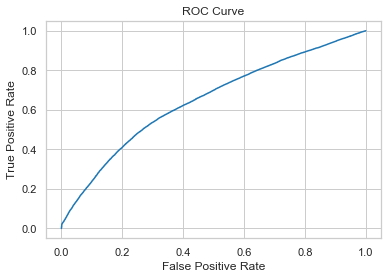

ROC AUC Score: 0.648248373556872
Reporting Time: 0.8 seconds


In [22]:
#Full Training Set Logistic Regression Model

logreg = LogisticRegression(max_iter = 1000)
TrainVal(logreg)

                                                 0         1
0   Homicide_Murder and non-negligent manslaughter -0.245686
1                                      VicSex_Male -0.158580
2                                    VicRace_Black -0.135036
3                   Weapon_Strangulation - hanging -0.100073
4                                         OriCases -0.095710
5                                   Month_December -0.059438
6                                           VicAge -0.054000
7                                    VicRace_Asian -0.049592
8                                   Month_November -0.045195
9                                    Month_October -0.040827
10                       Agentype_Municipal police -0.037235
11                                      Month_July -0.023067
12                                    Month_August -0.022607
13         Weapon_Blunt object - hammer, club, etc -0.022162
14                                 Month_September -0.021665
15                      

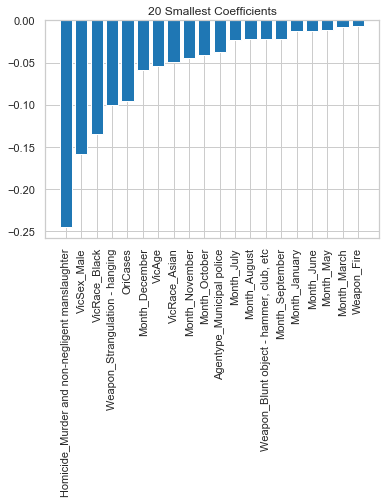

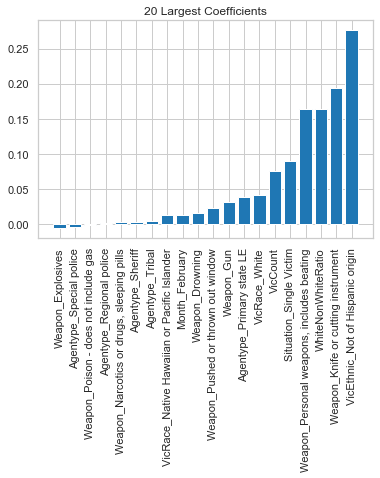

In [12]:
coef_df = pd.DataFrame(zip(model_df.drop('Solved', axis = 1).columns,logreg.coef_[0]))
coef_df.sort_values(1, inplace = True)
coef_df.reset_index(inplace = True, drop = True)

print(coef_df)

plt.bar(coef_df[0][0:20],coef_df[1][0:20])
plt.xticks(rotation = 'vertical')
plt.title('20 Smallest Coefficients')
plt.show()

plt.bar(coef_df[0][-20:],coef_df[1][-20:])
plt.xticks(rotation = 'vertical')
plt.title('20 Largest Coefficients')
plt.show()

Training Time: 0.2 seconds
Prediction Time: 0.2 seconds
Confusion Matrix:
 [[20989  1215]
 [19428  2775]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.95      0.67     22204
         1.0       0.70      0.12      0.21     22203

    accuracy                           0.54     44407
   macro avg       0.61      0.54      0.44     44407
weighted avg       0.61      0.54      0.44     44407

Accuracy: 53.51 %


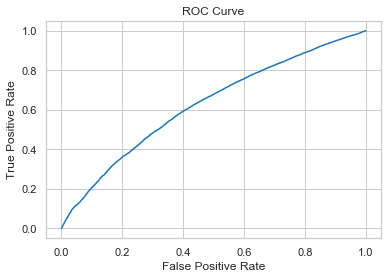

Reporting Time: 0.7 seconds


In [13]:
#Full Training Set Naive Bayes Model

bayes = GaussianNB()
TrainVal(bayes)

Training Time: 1.9 seconds
Prediction Time: 0.1 seconds
Confusion Matrix:
 [[13983  8221]
 [ 9705 12498]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.63      0.61     22204
         1.0       0.60      0.56      0.58     22203

    accuracy                           0.60     44407
   macro avg       0.60      0.60      0.60     44407
weighted avg       0.60      0.60      0.60     44407

Accuracy: 59.63 %


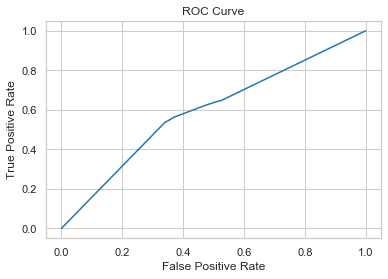

Reporting Time: 0.7 seconds


In [14]:
#Full Training Set Decision Tree Model

tree = DecisionTreeClassifier()
TrainVal(tree)

In [15]:
#Random Forest Model Cross Validation

#forest = RandomForestClassifier()
#CrossVal(forest)

Training Time: 35.1 seconds
Prediction Time: 5.2 seconds
Confusion Matrix:
 [[13570  8634]
 [ 7972 14231]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.61      0.62     22204
         1.0       0.62      0.64      0.63     22203

    accuracy                           0.63     44407
   macro avg       0.63      0.63      0.63     44407
weighted avg       0.63      0.63      0.63     44407

Accuracy: 62.6 %


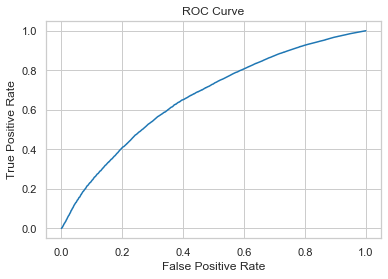

Reporting Time: 3.0 seconds


In [16]:
#Full Training Set Random Forest Model out-of-the-box

forest = RandomForestClassifier(n_jobs = 3, random_state = 33)
TrainVal(forest)

                                                 0         1
0      VicRace_Native Hawaiian or Pacific Islander  0.000090
1                                  Agentype_Tribal  0.000111
2               Weapon_Pushed or thrown out window  0.000112
3                         Agentype_Regional police  0.000165
4                                Weapon_Explosives  0.000250
5             Weapon_Poison - does not include gas  0.000298
6                                  Weapon_Drowning  0.000608
7                          Agentype_Special police  0.000632
8        Weapon_Narcotics or drugs, sleeping pills  0.000677
9                        Agentype_Primary state LE  0.001597
10                                     Weapon_Fire  0.001960
11                                   VicRace_Asian  0.002720
12                  Weapon_Strangulation - hanging  0.003819
13         Weapon_Blunt object - hammer, club, etc  0.004558
14       Weapon_Personal weapons, includes beating  0.005282
15                      

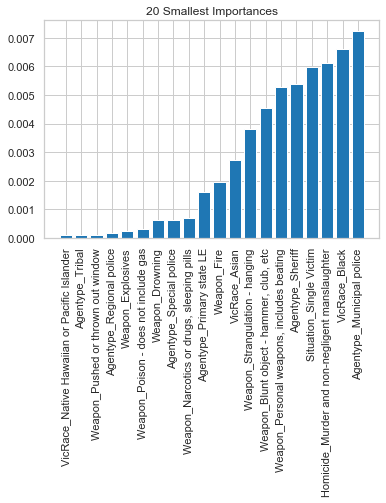

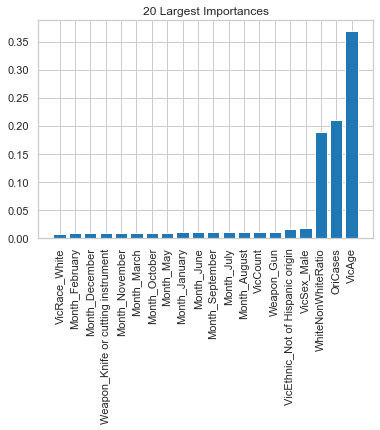

In [17]:
forest_feature_importance = pd.DataFrame(zip(model_df.drop('Solved', axis = 1).columns,forest.feature_importances_))
forest_feature_importance.sort_values(1, inplace = True)
forest_feature_importance.reset_index(inplace = True, drop = True)

print(forest_feature_importance)

plt.bar(forest_feature_importance[0][0:20],forest_feature_importance[1][0:20])
plt.xticks(rotation = 'vertical')
plt.title('20 Smallest Importances')
plt.show()

plt.bar(forest_feature_importance[0][-20:],forest_feature_importance[1][-20:])
plt.xticks(rotation = 'vertical')
plt.title('20 Largest Importances')
plt.show()


Training Time: 163.2 seconds
Prediction Time: 15.5 seconds
Confusion Matrix:
 [[15382  6822]
 [ 8354 13849]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22204
         1.0       0.67      0.62      0.65     22203

    accuracy                           0.66     44407
   macro avg       0.66      0.66      0.66     44407
weighted avg       0.66      0.66      0.66     44407

Accuracy: 65.83 %
Log Loss: 0.6176734397161707
Brier Score Loss: 0.21453643974619463


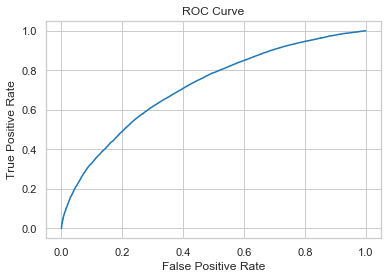

ROC AUC Score: 0.7167480860856368
Reporting Time: 7.6 seconds


In [23]:
#Full Training Set Random Forest

forest_1 = RandomForestClassifier(n_estimators = 1000,
                                  max_depth = 20,
                                  random_state = 33,
                                  n_jobs = 3)
TrainVal(forest_1)

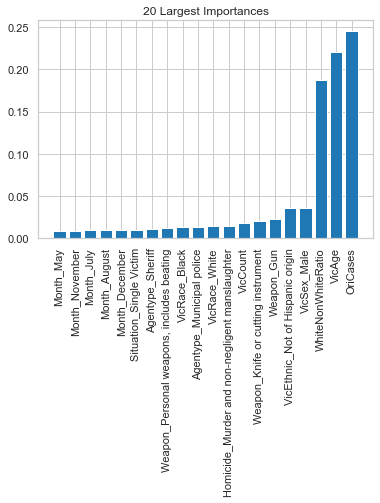

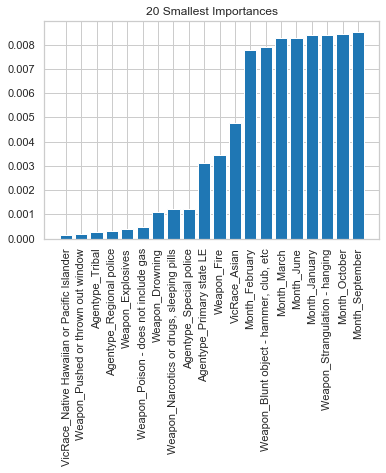

In [24]:
forest_feature_importance = pd.DataFrame(zip(model_df.drop('Solved', axis = 1).columns,forest_1.feature_importances_))
forest_feature_importance.sort_values(1, inplace = True)
forest_feature_importance.reset_index(inplace = True, drop = True)

plt.bar(forest_feature_importance[0][-20:],forest_feature_importance[1][-20:])
plt.xticks(rotation = 'vertical')
plt.title('20 Largest Importances')
plt.show()

plt.bar(forest_feature_importance[0][0:20],forest_feature_importance[1][0:20])
plt.xticks(rotation = 'vertical')
plt.title('20 Smallest Importances')
plt.show()

In [89]:
proba_df = pd.DataFrame(y_validation)
proba_df['Predicted Probability'] = forest_1.predict_proba(X_validation)[:,1]

In [28]:
chart_df.head()

,Solved,Predicted Probability
143332,0.0,0.250490
146343,1.0,0.701398
12346,0.0,0.429272
270194,0.0,0.653792
128102,1.0,0.715869


In [92]:
#The below bins by Predicted Probability
bins = np.arange(0,1.05,0.05)
labels = ['0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5',
          '0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1']
proba_df['Bin'] = pd.cut(proba_df['Predicted Probability'], bins = bins, labels = labels)
proba_df.reset_index(drop = True, inplace = True)
chart_df = proba_df.groupby('Bin')['Solved', 'Predicted Probability'].mean()
chart_df = pd.DataFrame(chart_df)
chart_df.reset_index(inplace = True)
chart_df.columns = ['Bin', 'Actual', 'Predicted']

print(chart_df)

     Bin    Actual  Predicted
0   0.05       NaN        NaN
1    0.1  0.128205   0.086356
2   0.15  0.168906   0.129901
3    0.2  0.167766   0.176682
4   0.25  0.199012   0.227030
5    0.3  0.253238   0.277348
6   0.35  0.293806   0.327026
7    0.4  0.374192   0.374306
8   0.45  0.426553   0.424482
9    0.5  0.477201   0.474225
10  0.55  0.535601   0.524904
11   0.6  0.600460   0.574932
12  0.65  0.624643   0.623785
13   0.7  0.688176   0.674505
14  0.75  0.736909   0.724606
15   0.8  0.786589   0.773880
16  0.85  0.827965   0.823006
17   0.9  0.886311   0.873464
18  0.95  0.932401   0.920214
19     1  0.907692   0.960392


C:\Users\Classy\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


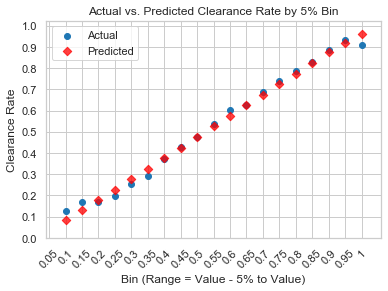

In [106]:
#plt.plot(chart_df.Bin, chart_df.Bin, label = 'Rough Bin Expected Clearance')
plt.scatter(chart_df.Bin, chart_df.Actual, label = 'Actual', alpha = 1)
plt.scatter(chart_df.Bin, chart_df.Predicted, color = 'r', marker = 'D', label = 'Predicted', alpha = 0.75)
plt.legend()
plt.title('Actual vs. Predicted Clearance Rate by 5% Bin')
plt.xticks(rotation = 45)
plt.xlabel('Bin (Range = Value - 5% to Value)')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.ylabel('Clearance Rate')
plt.show()

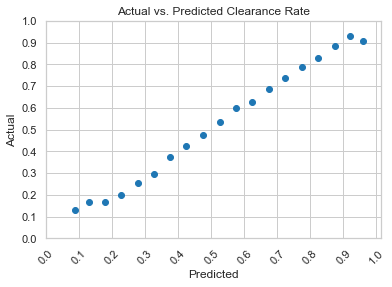

In [108]:
plt.scatter(chart_df.Predicted, chart_df.Actual)
plt.title('Actual vs. Predicted Clearance Rate')
plt.xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],rotation = 45)
plt.xlabel('Predicted')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.ylabel('Actual')
plt.show()

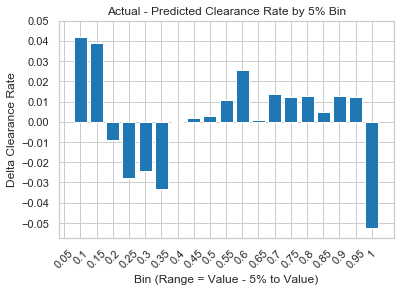

In [99]:
plt.bar(chart_df.Bin, chart_df.Actual - chart_df.Predicted,)
plt.title('Actual - Predicted Clearance Rate by 5% Bin')
plt.xticks(rotation = 45)
plt.xlabel('Bin (Range = Value - 5% to Value)')
plt.yticks([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])
plt.ylabel('Delta Clearance Rate')
plt.show()